<a href="https://colab.research.google.com/github/IsaacFigNewton/DAG-Based-Tokenization/blob/recreating-wordpiece/DAG_Text_Encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO


1.  Refactor the suffix tree composition algorithm to take a divide-and-conquer aka a split-and-merge approach using multithreading

Bring suffix tree composition complexity further down to logn by splitting on middle
most spaces into sub tasks

2.  Represent vectorization of text as fourth dimension, with token vector scaling corresponding to token frequencies or paths
3.  Create token distance tensor during dag mapping for added accuracy

# Install packages and import libraries

In [1]:
!pip install tensorflow-text

In [2]:
import time
import re
# from threading import Thread
# from concurrent.futures import ThreadPoolExecutor
import unittest

import math
import random
from queue import Queue
from collections import Counter
import numpy as np
import urllib.request as url
import pandas as pd
import json

from scipy.sparse.csgraph import connected_components
import scipy.sparse as sp
import tensorflow as tf
import tensorflow_text as tf_text
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# warnings.filterwarnings('ignore')

#Important functions

## Classes

###Utility

####Operational

In [3]:
def count_occurrences(text, delimiters=None):
    if not delimiters:
      delimiters = set()

    # Initialize a dictionary to keep track of occurrences
    occurrences = {s: 0 for s in delimiters}

    # For each delimiter, count occurrences using regex search
    for s in delimiters:
        # Use re.findall to count occurrences of each delimiter in the text
        occurrences[s] = len(re.findall(re.escape(s), text))

    return occurrences

In [4]:
def compile_regex(delimiters=None):
    if not delimiters:
      delimiters = set()

    # Join the strings with '|' and escape special characters
    regex_pattern = "|".join(re.escape(s) for s in delimiters)

    # Enclose the pattern in parentheses to group it
    return f"({regex_pattern})"

#### Vector Embedding

In [5]:
def calculate_distances_for_subgraph(labels, adjacency_matrix, subgraph_id):
    """
    Calculate Manhattan distances for nodes in a specific subgraph and update the distance matrix.

    Parameters:
    labels (numpy array): Array of subgraph labels for each node.
    adjacency_matrix (CSR matrix): A sparse adjacency matrix of the graph.
    subgraph_id (int): ID of the subgraph to process.
    """
    # extract a list of all the subgraph vertices in the current subgraph
    subgraph_vertices = np.where(labels == subgraph_id)[0]

    n = adjacency_matrix.shape[0]

    indices = []
    values = []
    # for each seed node
    for i in subgraph_vertices:
        # for each outgoing node in the subgraph
        for x in subgraph_vertices:
          # for each incoming node in the subgraph
          for y in subgraph_vertices:
              # if the entry, when double-checked, is found to be nonzero
              if adjacency_matrix[x, y] != 0 or i == x and x == y:
                  # calculate inverted Manhattan distance, kind of
                  #   since a node in the same row or column as the seed
                  #   must have a distance of 1 from the seed,
                  #   determine the shortest distance to either the row or column
                  #   this is a heuristic since it would take too long to re-traverse the dag from scratch

                  # if the entry represents the seed node
                  if i == x and x == y:
                    inverse_manhattan_distance = 1
                  else:
                    #   numerator is 0.75 to discount weight of non-self nodes
                    inverse_manhattan_distance = 0.75 / np.maximum(min(np.abs(x - i), np.abs(y - i)), 1)

                  # Store indices and values in lists
                  indices.append([i, x, y])
                  values.append(inverse_manhattan_distance)

    if not indices:
        print("Error, the entry for the seed node was not created in the tensor")
        return None

    # return for recombination with the entire graph's tensor
    return indices, values

In [6]:
def vectorize_adjacency_matrix(adjacency_matrix, low_mem=True):
    """
    Vectorize the adjacency matrix by calculating Manhattan distances for each subgraph.

    Parameters:
    adjacency_matrix (CSR matrix): Adjacency matrix of the graph.

    Returns:
    sparse CSR matrix: 3D distance matrix.
    """
    n = adjacency_matrix.shape[0]

    # Identify subgraphs and their labels
    num_subgraphs, labels = connected_components(adjacency_matrix, directed=False, return_labels=True)
    indices = []
    values = []

    if low_mem:
        # Calculate distances for each subgraph in series
        for subgraph_id in range(num_subgraphs):
            subgraph_distance_tensor = calculate_distances_for_subgraph(labels,\
                                                                        adjacency_matrix,\
                                                                        subgraph_id)

            # if there's a subgraph distance tensor to combine the original with...
            if subgraph_distance_tensor is not None:
                # Recombine the partial vectorizations given by the subgraphs into
                #   a single vectorization for the entire graph
                subgraph_indices, subgraph_values = calculate_distances_for_subgraph(labels,
                                                                                      adjacency_matrix,
                                                                                      subgraph_id)
                indices = indices + subgraph_indices
                values = values + subgraph_values
    else:
        # Calculate distances for each subgraph in parallel
        # Create and start threads for each subgraph
        threads = []
        # for subgraph_id in range(num_subgraphs):
        #     thread = Thread(target=calculate_distances_for_subgraph,
        #                     args=(labels,
        #                           adjacency_matrix,
        #                           subgraph_id))
        #     thread.start()
        #     threads.append(thread)

        # # Wait for all threads to complete
        # for thread in threads:
        #     thread.join()
        pass


    # print(indices, values)

    # Return a sparse tensor for storing the tokens' distance tensors/embeddings
    return tf.sparse.SparseTensor(indices=indices,
                                  values=values,
                                  dense_shape=[n, n, n])

In [7]:
def tensor_to_array(tensor):
  return tf.sparse.to_dense(tensor).numpy()

In [8]:
def get_tensor_slice(tensor, slice_index):
  # print("Getting slice for token ", slice_index)
  indices = tensor.indices.numpy()
  values = tensor.values.numpy()
  n = tensor.dense_shape.numpy()[0]
  new_indices = []
  new_values = []

  for i, index in enumerate(indices):
    if index[0] == slice_index:
      new_indices.append([index[1], index[2]])
      new_values.append(values[i])

  # print(new_indices, new_values)
  return tf.sparse.SparseTensor(indices=new_indices,
                                  values=new_values,
                                  dense_shape=[n, n])

In [43]:
def vectorize(adjacency_matrix, reversed_token_map, token_set):
  n = len(token_set)
  token_tensor = vectorize_adjacency_matrix(adjacency_matrix)

  # create a dictionary of all the tokens and their respective tensor embedding slices
  # print(token_tensor)
  token_vector_mappings = {reversed_token_map[i]: get_tensor_slice(token_tensor, i) for i in range(n)}

  for token in token_set:
      tok_vect_tensor = token_vector_mappings[token]

  # print(token_vector_mappings)

  return token_vector_mappings

#### Plotting and Printing

In [10]:
def plot_embeddings(embeddings, max_plots):
  if max_plots < 1:
    return

  i = 0
  for token, vector in embeddings.items():
    if (i % max(len(embeddings) * int(i/max_plots), 1) == 0):
        print("Embedding for'" + token + "':")
        dense_vector = tensor_to_array(vector)
        # print("embedding string: ", vector)


        # Convert the vector to its dense representation and create the heatmap
        sns.heatmap(dense_vector, annot=False, cmap='viridis')

        # Display the heatmap
        plt.show()
        i += 1

In [45]:
def plot_dag(dag_store, A=None, scaling=50, edge_width=1, k=2):
    print("Adjacency matrix:\n", A)

    if A is None:
        print("Adjacency matrix was empty/not defined")

    # Create a directed graph from the adjacency matrix
    G = nx.from_numpy_array(A, create_using=nx.DiGraph)

    # Relabel the token nodes
    G = nx.relabel_nodes(G, dag_store.reversed_token_map)

    # # Draw the graph without edge labels
    # # Convert nodes to strings before calculating length
    # nx.draw(G, with_labels=True, node_size=[scaling * len(str(node)) for node in G.nodes()],
    #         width=edge_width, font_size=8)


    # Calculate figure size based on the number of nodes
    num_nodes = len(G.nodes)
    num_edges = len(G.edges)
    graph_size = (num_nodes) + (2 * num_edges)

    figsize = graph_size * scaling/300
    font_size = 2 + math.sqrt(scaling)/5

    # Position nodes using the spring layout
    pos = nx.spring_layout(G, seed=42, k=k/num_nodes)

    # Calculate node sizes based on the length of the token text
    node_sizes = [scaling * len(node) for node in G.nodes()]

    plt.figure(figsize=(figsize, figsize), dpi=300)

    # Draw nodes with sizes proportional to the length of their text
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes)

    # Draw edges with widths based on edge weights
    nx.draw_networkx_edges(G,
                          pos,
                          width=edge_width,
                          arrowstyle='-|>',
                          connectionstyle="arc3,rad=0.2")

    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=font_size, font_family="sans-serif")

    # # Draw edge weight labels
    # edge_labels = nx.get_edge_attributes(G, "weight")
    # nx.draw_networkx_edge_labels(G, pos, edge_labels)

    # Customize and show plot
    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()

    plt.show()

### Storage

In [12]:
class DAGStore:
  def __init__(self,
               vertices=None,
               edge_set=None,
               token_index_map=None,
               adjacency_matrix=None):

      if vertices is None:
        vertices = dict()
      if edge_set is None:
        edge_set = set()

      self.vertices = vertices
      self.edge_set = edge_set
      self.token_index_map = token_index_map
      self.reversed_token_map = None
      # first dimension = outgoing token node
      # second dimension = incoming token node
      self.adjacency_matrix = adjacency_matrix

In [41]:
class FlatTreeStore:
    def __init__(self, child_dict=None, root=None):

        # a flattened tree of nodes,
        #   so that a node's tree membership can be checked more easily
        if child_dict is None:
            child_dict = dict()
        self.child_dict = child_dict
        self.root = root


    def tokenize(self, text, max_token_len):
        if self.root is None:
          raise ValueError("No root node provided to FlatTreeStore object")

        curr_node = self.root
        tokenization = []

        print(f"Token: '{text}'")

        # start at the end of the text
        i = len(text) -1
        while len(text) > 0:
          # get the next token as the aggregated suffix of the string
          next_token = text[i:]
          print(f"Next Token: '{next_token}'")

          # if the next token is a child of the current one
          if next_token in curr_node.keys_to_my_children:
            curr_node = self.child_dict[next_token]

          # otherwise, append the previous token,
          #    reset the text,
          #    and start back at the root of the suffix tree (which has single characters)
          else:
            tokenization.append(curr_node.token)
            curr_node = self.root
            text = text[:i]

          i -= 1

        print(f"Tokenization: {tokenization}")
        return tokenization

### SuffixNode Class
Let:
*    n=text length
*    b=mean block size
*    l=mean inter-block lexical diversity (l = n/b if every block has a unique suffix tree and l < n/b if some blocks have shared suffix tree compositions)

<br>

Blocked Ukkonen time complexity: O(n)
*   If split with preprocessing (O(n) time), parallelization in a divide-and-conquer approach would offer maximum time complexity of O(b*l)



pruning time complexity: O(log(b*l))

tokenization time complexity: O(log(b*l))

In [33]:
class SuffixNode:
    def __init__(self,
                 suffix=None,
                 token=None,
                 frequency=0,
                 parent=None,
                 keys_to_my_children=None,
                 flat_tree_store=None):
        self.suffix = suffix
        self.token = token
        self.frequency = frequency

        self.parent = parent

        # store tokens representing keys to children in the child_dict
        if keys_to_my_children is None:
            keys_to_my_children = set()
        self.keys_to_my_children = keys_to_my_children

        # store the child_dict separately
        if flat_tree_store is None:
            flat_tree_store = FlatTreeStore()
        self.flat_tree_store = flat_tree_store

    def __str__(self):
        return self.token


    def print_tree(self, indent=0):
      my_children = {self.flat_tree_store.child_dict[key] for key in self.keys_to_my_children}

      # Iterate over the child.suffixes (features) in the tree
      for child in my_children:
          print(' ' * indent + str(child.suffix) + ": " + str(child.frequency))
          # If the child is a SuffixNode, recursively print the subtree
          if isinstance(child, SuffixNode):
              child.print_tree(indent=indent + 4)
          else:
              print(' ' * (indent + 4) + "\"" + str(child.suffix) + "\": " + str(child.frequency))


    def set_token(self):
      if self.parent.token:
        self.token =  self.parent.token + self.suffix
      else:
        self.token = self.suffix


    def get_tree_in_node(self, child):
      old_suffix = child.suffix[i:]
      new_suffix = self.suffix[i:] if self.suffix else ""

      # Create the split node with frequency 0
      split_node = SuffixNode(suffix=child.suffix[:i],
                              frequency=child.frequency,
                              parent=self,
                              flat_tree_store=self.flat_tree_store)
      split_node.set_token()

      # Create the old_child (new suffix) with frequency 1
      old_child = SuffixNode(
                  suffix=new_suffix,
                  frequency=child.frequency,
                  parent=split_node,
                  flat_tree_store=self.flat_tree_store)
      old_child.set_token()

      # Create the new_child (original suffix) with the original child's frequency
      new_child = SuffixNode(suffix=old_suffix,
                            frequency=1,
                            parent=split_node,
                            flat_tree_store=self.flat_tree_store,
                            keys_to_my_children=child.keys_to_my_children)
      new_child.set_token()

      return split_node, old_child, new_child


    def split_edge(self, child, i):
      split_node, old_child, new_child = self.get_tree_in_node(child)

      # Remove the old child
      self.keys_to_my_children.remove(child.token)
      del self.flat_tree_store.child_dict[child.token]

      # Add the new split node as a child of the current node
      self.keys_to_my_children.add(split_node.token)
      self.flat_tree_store.child_dict[split_node.token] = split_node

      # Set the parent of the split_node
      split_node.parent = self

      # Transfer the children to the new split node's child (new_child)
      for grandchild_key in child.keys_to_my_children:
          grandchild = self.flat_tree_store.child_dict[grandchild_key]
          grandchild.parent = new_child
          new_child.keys_to_my_children.add(grandchild_key)

      # Set up the split_node's children
      split_node.keys_to_my_children = {new_child.token, old_child.token}
      self.flat_tree_store.child_dict[new_child.token] = new_child
      self.flat_tree_store.child_dict[old_child.token] = old_child


    def add_suffix(self, suffix):
      # Find the longest prefix match in the children
      for child_token in self.keys_to_my_children:
          child = self.flat_tree_store.child_dict[child_token]

          # Find the index of the longest common prefix
          i = 0
          while i < len(child.suffix) and i < len(suffix) and child.suffix[i] == suffix[i]:
              i += 1

          # If there is a common prefix
          if i > 0:
              # Update the frequency of the current node
              child.frequency += 1
              print(f"{child_token}: {child.frequency}")
              print()

              # If the common prefix is the entire child key, recurse into that child
              if i == len(child.suffix):
                  child.add_suffix(suffix[i:])

              # If the common prefix is only part of the child key, split the edge
              elif i < len(suffix):
                  self.split_edge(child, i)

              return

      # No matching prefix, add the suffix as a new child
      new_child = SuffixNode(suffix=suffix,
                              frequency=1,
                              parent=self,
                              flat_tree_store=self.flat_tree_store)
      new_child.set_token()

      self.keys_to_my_children.add(new_child.token)
      self.flat_tree_store.child_dict[new_child.token] = new_child


    def merge_trees(self, other):
        other_tree = other.flat_tree_store.child_dict

        shared_tokens = set(self.keys_to_my_children).intersection(set(other.keys_to_my_children))
        other_unique_tokens = set(other.keys_to_my_children).difference(set(self.keys_to_my_children))

        # combine children held in common between both suffix trees
        for token in shared_tokens:
            my_child = self.flat_tree_store.child_dict[token]
            other_child = other_tree[token]

            # combine the childrens' frequencies
            self.flat_tree_store.child_dict[token].frequency += other_child.frequency

            # recursively merge any grandchildren that might be held in common
            self.flat_tree_store.child_dict[token].merge_trees(other_child)

        # add the other tree's unique children to this tree
        for token in other_unique_tokens:
            other_child = other_tree[token]

            other_child.parent = self
            self.flat_tree_store.child_dict[other_child.token] = other_child


    def find_split_point(text, delimiters):
        if not delimiters:
            return len(text) // 2

        # Find all matches for the delimiter regex
        matches = list(re.finditer(delimiters, text))

        if not matches:
            return None

        # Find the match closest to the middle of the string
        mid = len(text) // 2
        best_match = min(matches, key=lambda m: abs(m.start() - mid))

        return best_match.start()


    # add the delimiter frequencies back into the suffix tree's storage
    def add_delimiters_to_tree(self, text="", delimiters=None):
        delimiter_counts = count_occurrences(text, delimiters)

        self.keys_to_my_children.update(set(delimiter_counts.keys()))
        self.flat_tree_store.child_dict.update({
            key: SuffixNode(suffix=key,
                              token=key,
                              frequency=value,
                              parent=self,
                              flat_tree_store=self.flat_tree_store)\
            for key, value in delimiter_counts.items()
        })


    def base_build_tree(self, text="", delimiters=None, delimiter_regex=r"\n"):
        # split the text into blocks, where each block is an independent clause
        clauses = re.split(delimiter_regex, text)
        # print(set(clauses))

        for string in clauses:
            print("Building suffix tree for '", string, "'...")
            # loop through the string, starting with the last character
            for i in range(0, len(string)):
                suffix = string[len(string) - i - 1:]

                # add the suffix to the tree
                self.add_suffix(suffix)

        self.add_delimiters_to_tree(text=text,
                                    delimiters=delimiters)


    def parallelized_build_tree(text, delimiters=None, delimiter_regex=r"\n"):
        if len(text) == 0:
            return SuffixNode()

        # Find the best split point using delimiters
        split_point = SuffixNode.find_split_point(text, delimiter_regex)

        # if the text has been split down to the size of a word
        if split_point == None or split_point == 0 or split_point == len(text)-1:
            root = SuffixNode()

            # loop through the string, starting with the last character
            for i in range(0, len(text)):
                suffix = text[len(text) - i - 1:]

                # add the suffix to the tree
                root.add_suffix(suffix)

            return root

        left_half = text[:split_point]
        right_half = text[split_point+1:]

        print(left_half)

        left_tree = SuffixNode.parallelized_build_tree(left_half,
                                                       delimiters=delimiters,
                                                       delimiter_regex=delimiter_regex)
        right_tree = SuffixNode.parallelized_build_tree(right_half,
                                                        delimiters=delimiters,
                                                        delimiter_regex=delimiter_regex)

        left_tree.merge_trees(right_tree)

        # WARNING: THIS MAY DEFEAT THE PURPOSE OF THE PARALLELIZATION, BRING T(n) TO O(n)
        left_tree.add_delimiters_to_tree(text=text,
                                    delimiters=delimiters)

        return left_tree


    def prune_tree(self, threshold=2):
        # If the node has no children (ie it's a leaf), return
        if not self.keys_to_my_children:
            # print("no children")
            return

        children_to_kill = set()
        # Recursively prune the tree
        for child_token in self.keys_to_my_children:
            child = self.flat_tree_store.child_dict[child_token]

            if isinstance(child, SuffixNode):
                # if the child is above the threshold or it's a single character token node
                if child.frequency >= threshold or child.parent is None:
                    # print("not removed")
                    self.flat_tree_store.child_dict[child_token].prune_tree(threshold)
                else:
                    # print("removed")
                    children_to_kill.add(child_token)

        for child_token in children_to_kill:
            # if the token's frequency falls below the threshold, prune it
            self.keys_to_my_children.remove(child_token)
            del self.flat_tree_store.child_dict[child_token]


    # set all the suffix tree nodes' token properties
    # return an aggregated set of all the tokens
    def get_tokens(self, prev_token=""):
        tokens = set(self\
                     .flat_tree_store\
                     .child_dict\
                     .keys())

        return tokens

In [15]:
def get_suffix_tree(text,
                      threshold,
                      delimiters=None,
                      tree=None,
                      test=True):
  # use the tree option in case a previous tree is to be pruned further
  suffix_tree = tree
  if suffix_tree is None:
    print("Building modified suffix tree...")

    # suffix_tree = SuffixNode(children = {SuffixNode(suffix=unique_char) for unique_char in set(text)})

    if test:
      print("Running suffix_tree.base_build_tree()...")
      # create a store for the tree nodes
      flat_tree_store = FlatTreeStore(child_dict={
          letter: SuffixNode(suffix=letter, token=letter) for letter in set(text)
      })
      delimiter_regex = compile_regex(delimiters)

      # point all the internal tree stores back at the main one
      for key in flat_tree_store.child_dict.keys():
        flat_tree_store.child_dict[key].flat_tree_store = flat_tree_store

      suffix_tree = SuffixNode(flat_tree_store=flat_tree_store,
                               keys_to_my_children=set(flat_tree_store.child_dict.keys()))
      # set the root of the flat tree store to the initial SuffixNode pointing to it
      suffix_tree.flat_tree_store.root = suffix_tree

      suffix_tree.base_build_tree(text,
                                  delimiters=delimiters,
                                  delimiter_regex=delimiter_regex)
    else:
      print("Running SuffixNode.parallelized_build_tree()...")
      suffix_tree = SuffixNode.parallelized_build_tree(text,
                                                       delimiters=delimiters,
                                                       delimiter_regex=delimiter_regex)


    # suffix_tree.print_tree()

  print("Pruning modified suffix tree...")
  suffix_tree.prune_tree(threshold=threshold)
  suffix_tree.print_tree()

  print("Getting token set...")
  tokens = suffix_tree.get_tokens()
  print(tokens)

  return suffix_tree, tokens

### CompositionDAGNode
construction time complexity: O(log(|V| + |E|))

In [47]:
class CompositionDAGNode:
    def __init__(self,
                 token=None,
                 frequency=0,
                 parents=None,
                 flat_tree_store=None,
                 dag_store=None):
        self.token = token
        self.frequency = frequency

        if parents is None:
            parents = list()
        self.parents = parents

        if flat_tree_store is None:
            flat_tree_store = FlatTreeStore()
        self.flat_tree_store = flat_tree_store

        if dag_store is None:
            dag_store = DAGStore()
        self.dag_store = dag_store

    def __str__(self):
        child_tokens = {child.token for child in self.flat_tree_store.child_dict.values()}
        parent_tokens = {parent.token for parent in self.parents}
        return f"Token: {self.token}\nParents: {parent_tokens}\nChildren: {child_tokens}"

    # make an edge between the current token and a successor
    def add_edge(self, child):
        # Add the larger token as a child of this token
        # print(self.flat_tree_store.child_dict)
        self.flat_tree_store.child_dict[child.token] = child

        # Add this token to the list of parents composing the larger token
        child.parents.append(self)

        # Add an edge to the edge list, using the current token's position
        #   in the child token as the edge weight
        self.dag_store.edge_set.add((self.token, child.token, len(child.parents) - 1))
        if self.token is not None and child.token is not None:
            self\
                .dag_store\
                .adjacency_matrix[self.dag_store.token_index_map[self.token], self.dag_store.token_index_map[child.token]] = 1


    # since this is recursively saving smaller tokens, it's basically depth-first
    def build_subgraph(self, suffix_node=None, suffix_tokenization=[]):
      vertices = self.dag_store.vertices

      for token in suffix_tokenization:

        # if the predecessor token is not in the vertex store,
        #   recursively build a sub-graph of suffix tokens
        if token not in vertices.keys():
            # create a new dag node for the current token
            #   and put it in the vertex store
            vertices[token] = CompositionDAGNode(token=token,
                                                 frequency=suffix_node\
                                                              .flat_tree_store\
                                                              .child_dict[token]\
                                                              .frequency,
                                                 dag_store = self.dag_store)

            # break the missing token into even smaller tokens using the largest available smaller tokens
            curr_suffix_tokenization = suffix_node.flat_tree_store.tokenize(text=token,
                                                max_token_len=len(token) - 1)
            # build a subgraph from the smaller tokens
            temp_vert = vertices[token]
            temp_vert, additional_vertices = temp_vert.build_subgraph(suffix_node, curr_suffix_tokenization)
            vertices.update(additional_vertices)

            vertices[token] = temp_vert

        # base case: if the predecessor is in the vertex store
        #   add an edge from the current node's predecessor to it
        vertices[token].add_edge(self)

      return self, vertices


    # do breadth-first accumulation of the suffix tree into the dag
    def suffix_tree_to_dag(self, suffix_tree):
        print("Building DAG from modified suffix tree...")

        all_tokens = suffix_tree.get_tokens()
        # create a dict for mapping tokens to indices in the adjacency matrix
        token_list = list(all_tokens)
        self.dag_store.token_index_map = {token_list[i]: i for i in range(len(token_list))}
        self.dag_store.reversed_token_map = {v: k for k, v in self.dag_store.token_index_map.items()}
        # initialize the adjacency matrix in LIL format
        #   for more efficient memory usage during composition and later modifications
        self.dag_store.adjacency_matrix = sp.lil_matrix((len(all_tokens), len(all_tokens)))

        # print("lil adjacency matrix:\n", self.dag_store.adjacency_matrix)

        vertices = self.dag_store.vertices
        vertices[self.token] = self

        suffix_node_queue = Queue()
        suffix_node_queue.put(suffix_tree)

        while not suffix_node_queue.empty():
            # get the next suffix node from the queue
            current_suffix_node = suffix_node_queue.get()

            if current_suffix_node.token is not None and current_suffix_node.token not in all_tokens:
                raise KeyError("current_suffix_node.token not in all_tokens")

            # create a dag vertex and add it to the set of vertices
            vert = CompositionDAGNode(token=current_suffix_node.token,
                                      frequency=current_suffix_node.frequency,
                                      dag_store = self.dag_store)
            vertices[vert.token] = vert

            # if it's the root of the base dag or one of the top-level tokens, just add it to the vertex dict
            if current_suffix_node.parent is None or current_suffix_node.parent.token is None:
                vertices[current_suffix_node.token] = vert
                # add an edge from the base graph's root to the top-level token
                self.add_edge(vert)

            # otherwise, add edges
            else:
                # tokenize the current token using the largest available smaller tokens
                current_tokenization = current_suffix_node.flat_tree_store.tokenize(current_suffix_node.token,
                                                                    len(current_suffix_node.token) - 1)

                temp_vert = vert
                temp_vert, additional_vertices = temp_vert.build_subgraph(current_suffix_node, current_tokenization)
                vertices[vert.token] = temp_vert
                vertices.update(additional_vertices)

            # add all the current node's children to the queue
            for child_token in current_suffix_node.keys_to_my_children:
                suffix_node_queue.put(current_suffix_node.flat_tree_store.child_dict[child_token])

        # print("lil djacency matrix after processing: ", self.dag_store.adjacency_matrix)

        # convert the LIL adjacency matrix to CSR format for more efficient modification
        self.dag_store.adjacency_matrix = sp.csr_matrix(self.dag_store.adjacency_matrix)

        # print("Sparse adjacency matrix:\n", self.dag_store.adjacency_matrix)

        self.dag_store.edge_set = {(pre, cum, pos) for pre, cum, pos in self.dag_store.edge_set if pre is not None}

#Testing

## Variables and functions

###Unit Tests

In [17]:
class SuffixTests(unittest.TestCase):
  def testTreeComposition():
    text == "abbabababba"

    suffix_tree, tokenizations[(text, min_freq)] = get_suffix_tree(text,
                                                                 min_freq=2,
                                                                 delimiters={" ", "\n"},
                                                                 tree=None,
                                                                 test=True)
    token_set = set(suffix_tree.flat_tree_store.child_dict.keys())
    base_token_set = {'bba', '', 'abababba', 'b', 'abba', 'ba', 'baa'}
    print(token_set, base_token_set)
    self.assertEqual(token_set, base_token_set)

###Testing function

In [18]:
def run_test(text,
             min_freq,
             delimiters=None,
             tree=None,
             test=True):
  suffix_tree, tokenizations[(text, min_freq)] = get_suffix_tree(text,
                                                                 min_freq,
                                                                 delimiters=delimiters,
                                                                 tree=tree,
                                                                 test=test)
  # print("modified suffix tree composed in ", time.time() - start_time, " seconds.")
  # print_tree(suffix_tree)

  composition_dag = CompositionDAGNode()
  # start_time = time.time()
  composition_dag.suffix_tree_to_dag(suffix_tree)
  # end_time = time.time() - start_time
  # print("dag composed in ", end_time, " seconds.")

  if (min_freq % int(max(freq_range)/num_graphs_to_plot) == 0):
      plot_dag(composition_dag.dag_store,
               A=composition_dag.dag_store.adjacency_matrix,
               k=4,
               scaling=25)

  # get tensor embeddings for all vertices
  start_time = time.time()
  token_vector_mappings = vectorize(composition_dag.dag_store.adjacency_matrix,
                                    composition_dag.dag_store.reversed_token_map,
                                    tokenizations[(text, min_freq)])
  end_time = time.time() - start_time

  # return {(pre, cum, pos+1) for pre, cum, pos in composition_dag.dag_store.edge_set if pre is not None}
  return end_time, suffix_tree, token_vector_mappings

###Variables

In [19]:
# freq_range = range(50, 1050, 50)
freq_range = range(2, 12, 2)
folds = 1
num_graphs_to_plot = 10
max_vector_plots = 2
tokenizations = dict()
test_results = {
    "min frequency": [],
    "test number": [],
    "mean time": [],
}
# for some reason word parsing only works with space characters and no other whitespace
delimiters = {" ", "\n"}   #r"\n",     #r"\n\n|.\n|\)\n|:|\.\.\.",
test = True

In [20]:
# test_url = "https://courses.cs.washington.edu/courses/cse163/20wi/files/lectures/L04/bee-movie.txt"
# with url.urlopen(test_url) as f:
#     text = f.read().decode('utf-8')
# # previously 454:500
# text = text[454:500]
# # text = text[0:500]
text = "black. Yellow, black.\n :\nOoh, black and yellow"
text = "abbabababba"
tests = [text]

print(text[:50])

abbabababba


## Run tests

In [21]:
# unittest.main()

minimum frequency:  2
Building modified suffix tree...
Running suffix_tree.base_build_tree()...
Building suffix tree for ' abbabababba '...
a: 1

b: 1

b: 2

b: 3

ba: 2

abba: 2

b: 4

ba: 3

babba: 2

b: 5

b: 6

bba: 2

abababba: 2

Pruning modified suffix tree...
: 2
b: 6
    ba: 2
    : 2
        a: 2
Getting token set...
{'', 'baa', 'abba', 'bba', 'b', 'abababba', 'ba'}
Building DAG from modified suffix tree...
Token: ''
Tokenization: []
Token: 'ba'
Next Token: 'a'
Next Token: 'b'
Next Token: 'b'
Tokenization: [None, 'b']
Token: 'bba'
Next Token: 'a'
Next Token: 'b'
Next Token: 'bb'
Tokenization: [None, 'b']
Token: 'baa'
Next Token: 'a'
Next Token: 'a'
Next Token: 'b'
Next Token: 'b'
Tokenization: [None, None, 'b']
Adjacency matrix:    (4, 1)	1.0
  (4, 3)	1.0
  (4, 6)	1.0


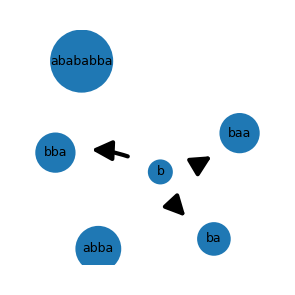

Embedding for'':


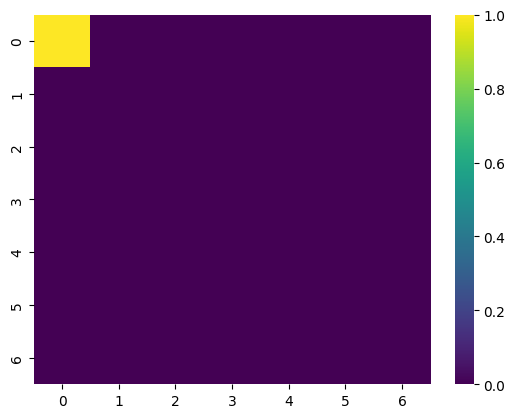

Embedding for'baa':


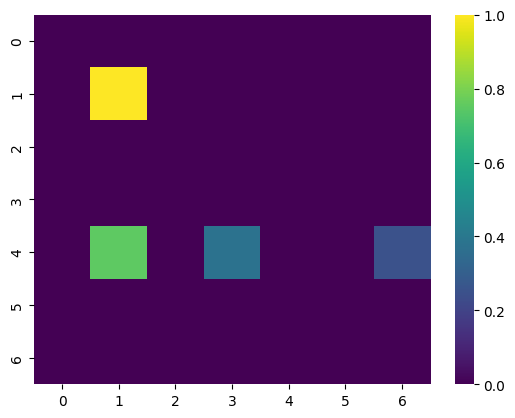

minimum frequency:  4
Pruning modified suffix tree...
b: 6
Getting token set...
{'baa', 'abba', 'abababba', 'b'}
Building DAG from modified suffix tree...
Adjacency matrix:  


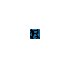

Embedding for'baa':


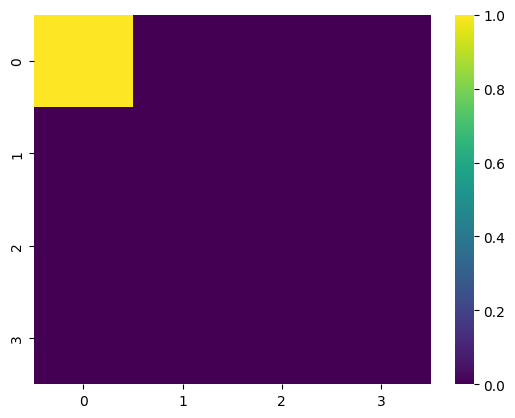

Embedding for'abba':


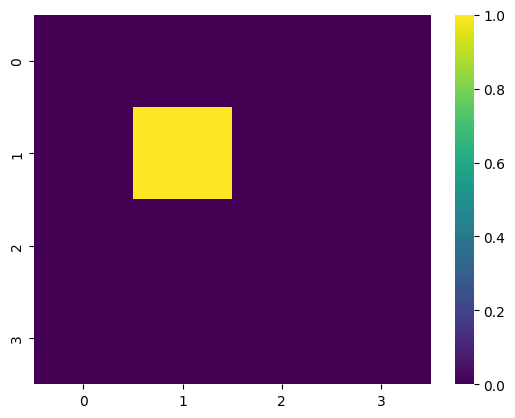

minimum frequency:  6
Pruning modified suffix tree...
b: 6
Getting token set...
{'baa', 'abba', 'abababba', 'b'}
Building DAG from modified suffix tree...
Adjacency matrix:  


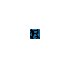

Embedding for'baa':


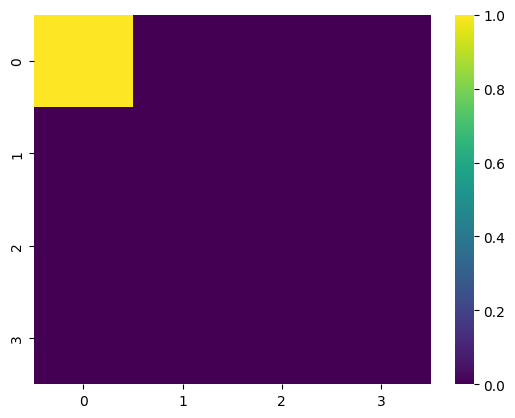

Embedding for'abba':


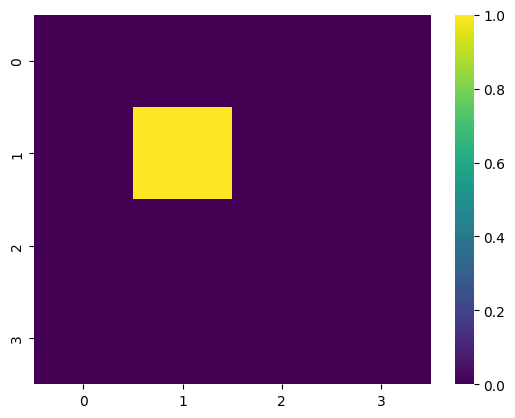

minimum frequency:  8
Pruning modified suffix tree...
b: 6
Getting token set...
{'baa', 'abba', 'abababba', 'b'}
Building DAG from modified suffix tree...
Adjacency matrix:  


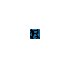

Embedding for'baa':


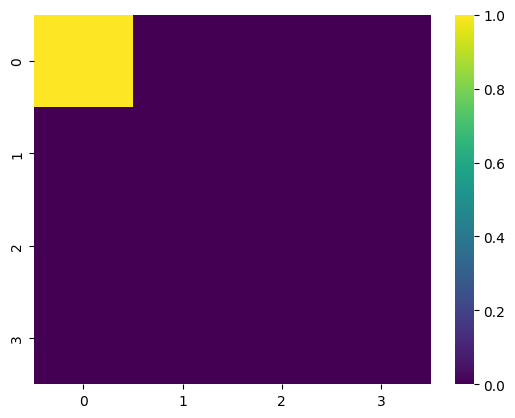

Embedding for'abba':


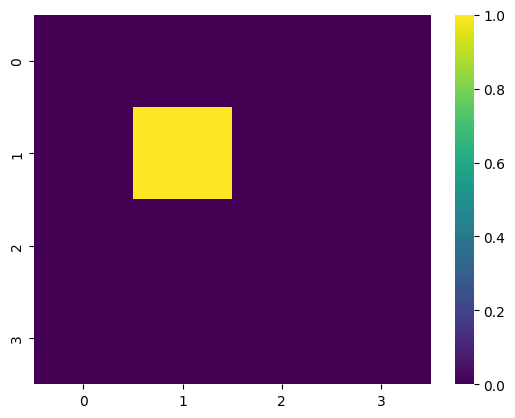

minimum frequency:  10
Pruning modified suffix tree...
b: 6
Getting token set...
{'baa', 'abba', 'abababba', 'b'}
Building DAG from modified suffix tree...
Adjacency matrix:  


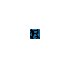

Embedding for'baa':


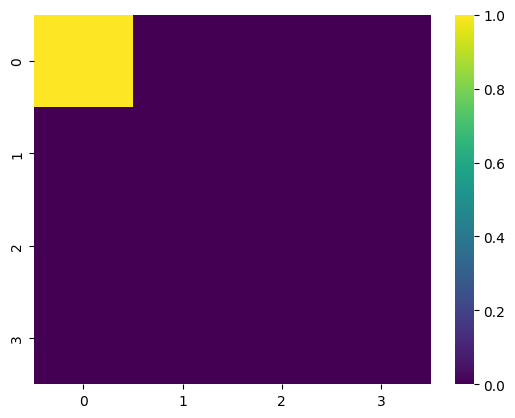

Embedding for'abba':


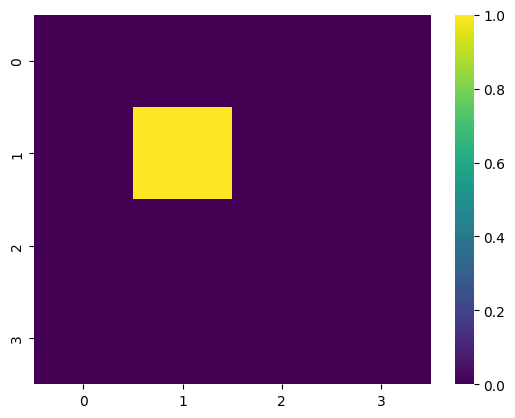

In [44]:
prev_trees = dict()

for min_freq in freq_range:
  print("minimum frequency: ", min_freq)

  for i in range(len(tests)):
    # print("test ", i)
    # if there's no previous tree stored for this test
    if i not in prev_trees.keys():
      prev_trees[i] = None

    mean_time = 0
    for fold in range(folds):
      new_time=0
      new_time, prev_trees[i], token_vector_mappings = run_test(text=tests[i],
                                                        min_freq=min_freq,
                                                        delimiters=delimiters,
                                                        tree=prev_trees[i],
                                                        test=test)
      mean_time += new_time

    plot_embeddings(token_vector_mappings, max_vector_plots)

    test_results["min frequency"].append(min_freq)
    test_results["test number"].append(i)
    test_results["mean time"].append(mean_time/folds)

print()

In [ ]:
tests_df = pd.DataFrame.from_dict(test_results)
tests_df.head()

In [ ]:
plt.plot(tests_df["min frequency"],
          tests_df["mean time"]
)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Min Frequency (log scale)')
plt.ylabel('Mean Time (log scale)')
plt.show()